# Predicting Match Outcomes

In this analysis I will use various Machine Learning algorithms to create a model that accurately predicts match outcomes.

In [3]:
#SQL Imports
import mysql.connector
#Pandas imports
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt

from dotenv import load_dotenv
import os

In [4]:
load_dotenv()

mydb = mysql.connector.connect(
  host="localhost",
  user=os.getenv("DB_USER"),
  passwd=os.getenv("DB_PASSWORD"),
  database="NRL_data"
)
mycursor = mydb.cursor()

## 1. Create dataframe of aggregated stats for each match

First I will compile a dataframe of match stats for each team in each match by aggregating individual player stats for each team. In addition to the statistics stored in the database, I will generate additional statistics that calculate averages and percentages.

In [5]:
query = pd.read_sql_query('''
    SELECT * 
    FROM PlayerMatchStats
''', mydb)
player_stat_df = pd.DataFrame(query)
match_stat_df = player_stat_df.groupby(['match_id','team_id']).sum().reset_index()
match_stat_df = match_stat_df.drop(columns=['id', 'player_id', 'position_id', 'minutes_played'])
#match_stat_df.columns
#print(match_stat_df.dtypes)

In [4]:
def get_averages(df):
    df['metres_per_kick'] = df['kicking_metres'] / df['kicks']
    df['metres_per_run'] = df['total_run_metres'] / df['total_runs']
    df['metres_ran_per_try'] = df['total_run_metres'] / df['tries']
    df['tackle_percentage'] = df['tackles_made'] / (df['tackles_made'] + df['tackles_missed'] + df['ineffective_tackles'])
    return df
match_stat_df = get_averages(match_stat_df)
match_stat_df = match_stat_df.drop(columns=['average_play_ball_seconds']).fillna(0)
match_stat_df.head()

,match_id,team_id,points,tries,conversions,conversion_attempts,penalty_goals,field_goals,total_runs,total_run_metres,...,handling_errors,one_on_ones_lost,penalties,on_report,sin_bins,send_offs,metres_per_kick,metres_per_run,metres_ran_per_try,tackle_percentage
0,1,1,12,2,1,2,1,0,130,1076,...,11,0,9,1,0,0,27.285714,8.276923,538.000000,0.871465
1,1,14,34,5,4,5,3,0,168,1618,...,9,2,7,0,0,0,28.117647,9.630952,323.600000,0.888060
2,2,6,18,3,2,3,1,0,178,1648,...,10,0,11,0,0,0,21.846154,9.258427,549.333333,0.888350
3,2,8,19,3,3,3,0,1,192,1425,...,6,0,9,0,0,0,25.619048,7.421875,475.000000,0.846535
4,3,4,14,2,2,2,1,0,134,1144,...,12,0,10,0,0,0,20.928571,8.537313,572.000000,0.865952


Next, I will combine the dataframe of aggregated player stats with the match date and a boolean column to indicate whether or not that team won the match.

In [5]:
#Generate df of data pertaining to each match
match_query = pd.read_sql_query('''
    SELECT id, date, round, home_team_id, home_score, away_team_id, away_score, winner, home_odds, away_odds, draw_odds
    FROM Matches
''', mydb)
match_df = pd.DataFrame(match_query).rename(columns={'id': 'match_id'})
match_df['date'] = pd.to_datetime(match_df['date'])

#Add date to match_stat_df
match_stat_df = pd.merge(match_stat_df, match_df[['match_id', 'date', 'winner']], on='match_id', how='inner')
match_stat_df['is_winner'] = match_stat_df.apply(lambda x: 1 if x['team_id'] == x['winner'] else 0, axis=1)
match_stat_df = match_stat_df.drop(columns='winner')
match_stat_df.head()

,match_id,team_id,points,tries,conversions,conversion_attempts,penalty_goals,field_goals,total_runs,total_run_metres,...,penalties,on_report,sin_bins,send_offs,metres_per_kick,metres_per_run,metres_ran_per_try,tackle_percentage,date,is_winner
0,1,1,12,2,1,2,1,0,130,1076,...,9,1,0,0,27.285714,8.276923,538.000000,0.871465,2018-03-08,0
1,1,14,34,5,4,5,3,0,168,1618,...,7,0,0,0,28.117647,9.630952,323.600000,0.888060,2018-03-08,1
2,2,6,18,3,2,3,1,0,178,1648,...,11,0,0,0,21.846154,9.258427,549.333333,0.888350,2018-03-09,0
3,2,8,19,3,3,3,0,1,192,1425,...,9,0,0,0,25.619048,7.421875,475.000000,0.846535,2018-03-09,1
4,3,4,14,2,2,2,1,0,134,1144,...,10,0,0,0,20.928571,8.537313,572.000000,0.865952,2018-03-09,0


## 2. Create classes for teams and matches

I will now create a Teams class and a Matches class. The Teams class will be used to create objects for each individual team. Each team object will contain all of the match stats for that team in addition to the stats of their opponent.

The match objects created from the Matches class will consist of two team objects. In order to create the final dataset on which I will train and test machine learning algorithms, I will loop through each match object and pull out the stats for each team that could be significant.

In [6]:
class Teams:
    all_teams = {}
    
    def __init__(self, name, id):
        self.name = name
        self.id = id
        self.match_stats = match_stat_df[match_stat_df['team_id'] == self.id]
        self.opposition_stats = self.get_opposition_stats()
        Teams.all_teams[self.name] = self
    
    #This function is currently in progress
    def get_roster(self):
        roster_df = player_stat_df[player_stat_df['team_id'] == self.id]
        roster_df = pd.merge(roster_df, match_df[['match_id', 'date']], on='match_id', how='inner')
        for match in list(roster_df['match_id'].unique()):
            #print(roster_df.head())
            df = roster_df[roster_df['match_id'] == match]
            df = list(df['player_id'])
            #print(df)
    
    def get_opposition_stats(self):
        match_ids = list(self.match_stats['match_id'])
        opposition_df = match_stat_df[(match_stat_df['match_id'].isin(match_ids)) & (match_stat_df['team_id'] != self.id)]
        return opposition_df
    
    def get_stats_most_recent_matches(self, date, x=1):
        date_df = self.match_stats[self.match_stats['date'] < date].sort_values('date', ascending=False)
        date_df = date_df.drop(columns=['date'])
        averages_df = date_df.head(x).sum() / x
        return averages_df
    
    def get_opposition_stats_most_recent_matches(self, date, x=1):
        date_df = self.opposition_stats[self.opposition_stats['date'] < date].sort_values('date', ascending=False)
        date_df = date_df.drop(columns=['date'])
        averages_df = date_df.head(x).sum() / x
        return averages_df
    
    def get_season_averages(self, year, self_or_opposition = 'self'):
        if self_or_opposition == 'opposition':
            stats = self.opposition_stats
        else:
            stats = self.match_stats
        date_df = stats[stats['date'].dt.year == year]
        date_df.drop(columns=['date'])
        averages_df = date_df.sum() / date_df.shape[0]
        return averages_df

    
#Create a class object for each team

#1. Get team name and id from database
team_names_and_ids = pd.DataFrame(pd.read_sql_query('SELECT id, nickname FROM Teams', mydb)).set_index('nickname').to_dict()['id']
#2. Loop through this the above dataframe to create Team objects
for name in team_names_and_ids.keys():
     Teams(name, team_names_and_ids[name])

In [8]:
class Matches:
    all_matches = {}
    
    def __init__(self, match_id, round, date, home_team, away_team, winner=None, home_odds=None, away_odds=None):
        self.id = match_id
        self.round = round
        self.date = date
        self.season = self.date.year
        self.home = home_team
        self.home_odds = home_odds
        self.away = away_team
        self.away_odds = away_odds
        if home_team.id == winner:
            self.winner = home_team
            self.home_winner = True
        else:
            self.winner = away_team
            self.home_winner = False
        self.stats = self.get_match_stats()
        self.identifier = str(self.date.date()) + '_' + str(self.id) + '_' + self.home.name + '-v-' + self.away.name
        Matches.all_matches[self.identifier] = self
    
    def get_match_stats(self):
        match_stats = pd.DataFrame()
        home_stats = self.home.match_stats[self.home.match_stats['match_id'] == self.id]
        away_stats = self.away.match_stats[self.away.match_stats['match_id'] == self.id]
        for column in list(home_stats.columns)[2:-2]:
            match_stats['h_' + column] = [home_stats[column].values[0]]
            match_stats['a_' + column] = [away_stats[column].values[0]]
            #match_stats['diff_' + column] = match_stats['h_' + column] - match_stats['a_' + column]
        return match_stats
    
    #This function will contain the final algorithm
    def predict_winner():
        pass

In [ ]:
#Function to create match objects from the df of match information from section 1
def create_match_objects(match):
    for key, value in Teams.all_teams.items():
        if match['home_team_id'] == Teams.all_teams[key].id:
            home_team = Teams.all_teams[key]
        if match['away_team_id'] == Teams.all_teams[key].id:
            away_team = Teams.all_teams[key]
    Matches(match['match_id'], match['round'], match['date'], home_team, away_team, match['winner'], match['home_odds'], match['away_odds'])
    
match_df.apply(lambda x: create_match_objects(x), axis = 1)



## 3. Feature Selection

First I will create a dataframe consisting of all home and away team stats for each individual match

In [ ]:
features = pd.DataFrame()

#Loop through each individual match and add to the 'features' df
for key in Matches.all_matches:
    match = Matches.all_matches[key]
    match_row = match.stats
    match_row['id'] = match.id
    match_row['h_win'] = match.home_winner
    features = features.append(match_row)
features = features.set_index('id')
features['h_win'] = features['h_win'].replace({True: 1, False: 0})
features.head()

#Correct issue with infinity values...occurs in metres_ran_per_try when no tries were scored
features = features.replace([np.inf, -np.inf], 0)
filter_ = [col for col in features if (col.startswith('h_') | col.startswith('a_'))]
features = features[filter_]

Next, I calculate the ANOVA F-Values to determine which features are the most significant in predicting match outcomes. I use sklearn's SelectKBest object to select features with the highest F-Values.

In [12]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

X = features.iloc[:, :-1]
Y = features['h_win']

#Create a SelectKBest object to select features with the best ANOVOA F-Values
fvalue_selector = SelectKBest(score_func=f_classif, k=15)
fvalue_selector.fit_transform(X, Y)

f_scores_df = pd.DataFrame(dict(feature_names = X.columns, f_scores = fvalue_selector.scores_)).sort_values('f_scores', ascending=False)
f_scores_df[f_scores_df['f_scores'] > 60]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [26 27] are constant.
  UserWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,feature_names,f_scores
0,h_points,685.664954
1,a_points,676.611124
2,h_tries,564.665038
6,h_conversion_attempts,557.746359
3,a_tries,535.805577
7,a_conversion_attempts,527.801310
5,a_conversions,478.179379
4,h_conversions,429.497824
24,h_try_assists,380.860270
25,a_try_assists,341.249165


## Generate dataframes of historical data for making predictions

Below, I will create a dictionary of dataframes for making predictions. Each dataframe will contain home team and away team data for a few of the statistics that I found to be most highly significant in predicting wins. The four stats that I have chosen are points, line_breaks, total_run_metres, and tackles_made. Because a lot of these statistics are dependant upon each other, I tried to pick statistics with high F-Scores that are fairly independent. For example, "points" had the highest F-Scores while "tries" had the second highest F-scores. Since a try is worth 5 points, these two stats are extremely highly correlated. This is why I did not include tries as a feature column.

Another variable that I'm not sure of is how far back I should be pulling historical data for making predictions. Will I be more accurate going off of stats from a teams previous 10 matches or only the most recent two? For this reason I have created 10 different dataframes on which to run predictions. The first pulls stats from only the most recent match, the second pulls stats from the two most recent matches, and so on.

In [ ]:
predictions_data = {}
pd.DataFrame()

#'i' will be the number of prior matches for which we want to include historic data
for i in range(1, 11):
    predictions_data[str(i)] = pd.DataFrame()
    
    #Loop through each match
    for key in Matches.all_matches:
        
        #For each match instantiate a dictionary which will store key-value pairs for each statistical category
        prediction_row = {} 
        match = Matches.all_matches[key]
        prediction_row['match_id'] = match.id
        prediction_row['date'] = match.date
        year = match.season
        prediction_row['round'] = match.round
        
        #Each match is a class object which contains two Team objects (1 for the home team and 1 for the away team)
        h = match.home
        a = match.away
        
        if match.home_winner is True:
            prediction_row['home_winner'] = 1
        else:
            prediction_row['home_winner'] = 0
        
        
        team_stats = ['points', 'line_breaks', 'total_run_metres', 'tackles_made', 'is_winner']
        opposition_stats = ['points', 'line_breaks', 'total_run_metres', 'tackles_made']
        #We will end up renaming the columns for the away team stats so each category is from the home team perspective
        #For example we will view "away team points scored" as "points allowed by the home team"
        renaming_dict = {
            'points': 'points_allowed',
            'line_breaks': 'line_breaks_allowed',
            'total_run_metres': 'total_run_metres_allowed',
            'tackles_made': 'tackles_by_opposition'
        }
        
        #If the match round is a playoff or if its greater than the value of i, then we use i as the number of matches to go back for predictions
        if (np.isnan(match.round)) | int(match.round > i):
            home_stats = h.get_stats_most_recent_matches(match.date, i)[team_stats]
            home_opposition_stats = h.get_opposition_stats_most_recent_matches(match.date, i)[opposition_stats]
        
            away_stats = a.get_stats_most_recent_matches(match.date, i)[team_stats]
            away_opposition_stats = a.get_opposition_stats_most_recent_matches(match.date, i)[opposition_stats]
    
        #If the match is occurring in the opening round, we will use the previous season averages to make predictions
        elif int(match.round) == 1:
            home_stats = h.get_season_averages(year - 1)[team_stats]
            home_opposition_stats = h.get_season_averages(year - 1)[opposition_stats]
        
            away_stats = a.get_season_averages(year - 1)[team_stats]
            away_opposition_stats = a.get_season_averages(year - 1)[opposition_stats]
        
        #If the match round is less than the value of i, then we make predictions using a combination of previous season averages and averages for the current season
        else:
            home_stats = h.get_stats_most_recent_matches(match.date, int(match.round) - 1)[team_stats]
            home_stats = ((home_stats / i) * (i - int(match.round))) + ((h.get_season_averages(year - 1)[team_stats] / i) * int(match.round))
            
            away_stats = a.get_stats_most_recent_matches(match.date, int(match.round) - 1)[team_stats]
            away_stats = ((away_stats / i) * (i - int(match.round))) + ((a.get_season_averages(year - 1)[team_stats] / i) * int(match.round))
        
            home_opposition_stats = h.get_opposition_stats_most_recent_matches(match.date, int(match.round) - 1)[opposition_stats]
            home_opposition_stats = ((home_opposition_stats / i) * (i - int(match.round))) + ((h.get_season_averages(year - 1)[opposition_stats] / i) * int(match.round))
            
            away_opposition_stats = a.get_opposition_stats_most_recent_matches(match.date, int(match.round) - 1)[opposition_stats]
            away_opposition_stats = ((away_opposition_stats / i) * (i - int(match.round))) + ((a.get_season_averages(year - 1)[opposition_stats] / i) * int(match.round))
        
        
#             home_stats['is_winner'] = ((h.get_season_averages(year - 1)['is_winner'] / i) * int(match.round))\
#                 + ((home_stats['is_winner'] / i) * (i - int(match.round)))
#             away_stats['is_winner'] = ((a.get_season_averages(year - 1)['is_winner'] / i) * int(match.round))\
#                 + ((away_stats['is_winner'] / i) * (i - int(match.round)))

        #we rename columns for all opposition stats
        home_opposition_stats = home_opposition_stats.rename(renaming_dict)
        away_opposition_stats = away_opposition_stats.rename(renaming_dict)
        
        #we append h_ or a_ to indicate whether a column is for home or away stats
        for stat in team_stats:
            prediction_row['h_' + stat] = home_stats[stat]
            prediction_row['a_' + stat] = away_stats[stat]
        for key, value in home_opposition_stats.items():
            prediction_row['h_' + key] = home_opposition_stats[key]
            prediction_row['a_' + key] = away_opposition_stats[key]
        
        #Append each dictionary of match stats to its corresponding datafraame
        predictions_data[str(i)] = predictions_data[str(i)].append(prediction_row, ignore_index=True)
        
    #Convert datatype of each match_id to avoid errors
    predictions_data[str(i)]['match_id'] = predictions_data[str(i)]['match_id'].astype(int)
    
    #Order daataframes by match date for organizational purposes
    predictions_data[str(i)] = predictions_data[str(i)].sort_values(by='date')


In [20]:
#Give playoffs a round of 0 and correct errors with infinity values
for key in predictions_data:
    predictions_data[key]['round'] = predictions_data[key]['round'].fillna(0)
    predictions_data[key] = predictions_data[key].dropna(axis=0)
    predictions_data[key] = predictions_data[key].replace([np.inf, -np.inf], 0)
#predictions_data['5']

## Model Selection

Since predicting a match winner is a classification problem, I will test out the following algorithms:
- Logistic Regression
- Random Forest
- Gradient Boosting Tree

## Logistic Rregression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import seaborn as sns
sns.set()

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [61]:
for key in predictions_data:
    data = predictions_data[key]
    #data = data.replace([np.inf, -np.inf], 0)
    
    #Train algorithm on all matches before 2019
    #Test algorithm on 2019
    train = data[data['date'].dt.year < 2019]
    test = data[data['date'].dt.year == 2019]
    
    X_train = StandardScaler().fit_transform(train.drop(columns=['home_winner', 'match_id', 'round', 'date']))
    y_train = train['home_winner']
    
    lr = LogisticRegression()
    scores = cross_val_score(lr, X_train, y_train, cv = 10)
    print('Prior ' + key + ' matches: ' + str(np.round(scores.mean(), 4)))
    
    lr = LogisticRegression()
    X_test = StandardScaler().fit_transform(test.drop(columns=['home_winner', 'match_id', 'round', 'date']))
    y_test = test['home_winner']
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print(accuracy_score(y_test, y_pred))
    


Prior 1 matches: 0.5609
0.527363184079602
Prior 2 matches: 0.5806
0.5522388059701493
Prior 3 matches: 0.5795
0.5522388059701493
Prior 4 matches: 0.5766
0.5422885572139303
Prior 5 matches: 0.5755
0.5472636815920398
Prior 6 matches: 0.5717
0.5671641791044776
Prior 7 matches: 0.5983
0.5373134328358209
Prior 8 matches: 0.5876
0.5422885572139303
Prior 9 matches: 0.5847
0.5422885572139303
Prior 10 matches: 0.5844
0.5572139303482587


From the output above, it looks like our predictions are most accurate when using stats from each teams prior 7 matches.

Below I will limit our data to the dataframe which uses stats from the prior 7 matches. I will run the LogisticRegression algorithm once again to generate the coefficients of each feature. These will tell us which features were the most significant in predicting match outcomes.

In [1]:
data = predictions_data['7']
train = data[data['date'].dt.year < 2019]
test = data[data['date'].dt.year == 2019]

#data = data.replace([np.inf, -np.inf], 0)
X_train = data.drop(columns=['home_winner', 'match_id', 'round', 'date'])
#X_scaled = StandardScaler().fit_transform(X)
y_train = data['home_winner']
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

coefficients = log_reg.coef_
feature_importance = pd.Series(coefficients[0], index=X_train.columns)
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh()
plt.show()

NameError: name 'predictions_data' is not defined

I will now order each feature by its significance in predicting outcomes. I will run regressions first using the most significant feature, then the 2 most significnat features, and so on. This will help determine the optimal number of features to use in my prediction algorithm

In [62]:
feature_index = 0
for feature in list(ordered_feature_importance.sort_values(ascending=False).index):
    feature_index += 1
    features = list(ordered_feature_importance.sort_values(ascending=False).index)[:feature_index]
    X = StandardScaler().fit_transform(X_train[features])
    y = train['home_winner']
    
    lr = LogisticRegression()
    lr.fit(X, y)
    scores = cross_val_score(lr, X, y, cv = 10)
    #print(feature_index)
    print('Top ' + str(feature_index) + ' features: ' + str(np.round(scores.mean(), 4)))
    
    lr = LogisticRegression()
    test_refined = test.drop(columns=['home_winner', 'match_id', 'round', 'date'])
    X_test = StandardScaler().fit_transform(test_refined[features])
    y_test = test['home_winner']
    lr.fit(X, y)
    y_pred = lr.predict(X_test)
    print(accuracy_score(y_test, y_pred))

Top 1 features: 0.5748
0.5373134328358209
Top 2 features: 0.5791
0.5472636815920398
Top 3 features: 0.5783
0.5522388059701493
Top 4 features: 0.5835
0.5522388059701493
Top 5 features: 0.5765
0.5572139303482587
Top 6 features: 0.5852
0.5621890547263682
Top 7 features: 0.5853
0.5572139303482587
Top 8 features: 0.5904
0.5572139303482587
Top 9 features: 0.5861
0.5572139303482587
Top 10 features: 0.5948
0.572139303482587
Top 11 features: 0.5948
0.572139303482587
Top 12 features: 0.5887
0.5671641791044776
Top 13 features: 0.5922
0.5671641791044776
Top 14 features: 0.6105
0.5323383084577115
Top 15 features: 0.607
0.5323383084577115
Top 16 features: 0.6027
0.5422885572139303
Top 17 features: 0.5966
0.5373134328358209
Top 18 features: 0.5983
0.5373134328358209


In [ ]:
top_features = list(ordered_feature_importance.sort_values(ascending=False).index)[:10]

In [ ]:

X_train = StandardScaler().fit_transform(train[top_features])
y_train = train['home_winner']
X_test = StandardScaler().fit_transform(test[top_features])
y_test = test['home_winner']
    
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(accuracy)

By experimenting with a few different variables, I have arrived at a prediction accuracy of 55.7%

## Random Forest

When using a Random Forest Classifier to make predictions on match outcomes, I will start with the dataframe of stats from the previous 7 matches. Since a Random Forest is an assortment of Decision Trees, I will experiment with the number of Decision Tree models (n_estimators) to be used for the Random Forest assortment.

In [69]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = list(range(1, 300, 20))
random_forest_results = pd.DataFrame({'estimators': n_estimators})
random_state = 0

##Uncomment this if we want to run through all dataframes
#for key in predictionos_data:

for key in ['7']:
    data = predictions_data[key]
    data = data.replace([np.inf, -np.inf], 0)

    
    X = data.drop(columns=['home_winner', 'match_id', 'round', 'date'])
    X = X[list(ordered_feature_importance.sort_values(ascending=False).index)[:4]]
    y = data['home_winner']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
    #key_results = []
    accuracy_scores = []
    auc_scores = []
    for i in n_estimators:
        #random_state += 1
        forest = RandomForestClassifier(n_estimators = i, random_state=42)
        forest.fit(X_train, y_train)
        forest_pred = forest.predict(X_test)
        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, forest_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        auc_scores.append(roc_auc)
        
        score = np.round(accuracy_score(y_test, forest_pred), 4)
        accuracy_scores.append(score)
        #print('Previous ' + key + ' matches - ' + str(i) + ' estimators accuracy: ' + str(np.round(score, 4)))
    #random_forest_results[key] = key_results

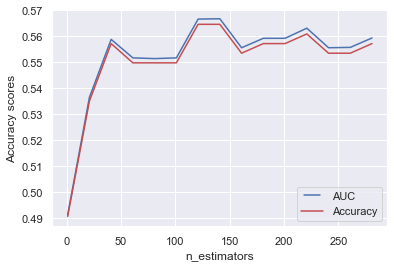

In [70]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, auc_scores, 'b', label="AUC")
line2, = plt.plot(n_estimators, accuracy_scores, 'r', label="Accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Accuracy scores')
plt.xlabel('n_estimators')
plt.show()

It lookslike our prediction accuracy is at its highest when our number of decision trees is set between 110 and 140. Below I will check to see if further increasing this value improves our accuracy scores.

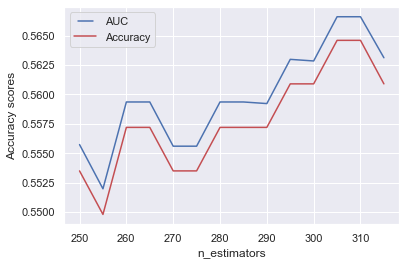

In [71]:
n_estimators = list(range(250, 320, 5))
random_forest_results = pd.DataFrame({'estimators': n_estimators})
random_state = 0
#for key in predictionos_data:
for key in ['7']:
    data = predictions_data[key]
    data = data.replace([np.inf, -np.inf], 0)

    
    X = data.drop(columns=['home_winner', 'match_id', 'round', 'date'])
    X = X[list(ordered_feature_importance.sort_values(ascending=False).index)[:4]]
    y = data['home_winner']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
    #key_results = []
    accuracy_scores = []
    auc_scores = []
    for i in n_estimators:
        #random_state += 1
        forest = RandomForestClassifier(n_estimators = i, random_state=42)
        forest.fit(X_train, y_train)
        forest_pred = forest.predict(X_test)
        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, forest_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        auc_scores.append(roc_auc)
        
        score = np.round(accuracy_score(y_test, forest_pred), 4)
        accuracy_scores.append(score)
        #print('Previous ' + key + ' matches - ' + str(i) + ' estimators accuracy: ' + str(np.round(score, 4)))
    #random_forest_results[key] = key_results
line1, = plt.plot(n_estimators, auc_scores, 'b', label="AUC")
line2, = plt.plot(n_estimators, accuracy_scores, 'r', label="Accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Accuracy scores')
plt.xlabel('n_estimators')
plt.show()

It looks like increasing our number of trees beyond 250 does not improve our predictions more than the 110 - 140 value we identified earlier.

Another hyperparameter I will experiement with is max_depths which specifies the maximum depth of each tree.

In [72]:
max_depths = np.linspace(1, 30, 32, endpoint=True)
random_forest_results = pd.DataFrame({'estimators': max_depths})
random_state = 0
#for key in predictionos_data:
for key in ['7']:
    data = predictions_data[key]
    data = data.replace([np.inf, -np.inf], 0)

    
    X = data.drop(columns=['home_winner', 'match_id', 'round', 'date'])
    y = data['home_winner']
    #key_results = []
    train_results = []
    test_results = []
    for i in max_depths:
        #random_state += 1
        forest = RandomForestClassifier(max_depth = i, random_state=42)
        forest.fit(X_train, y_train)
        train_pred = forest.predict(X_train)
        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        
        y_pred = forest.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)

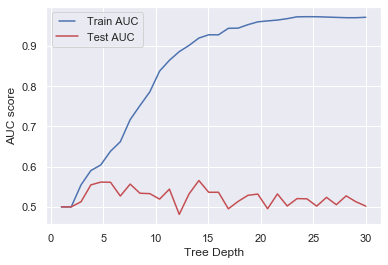

In [73]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('Tree Depth')
plt.show()

Our Area Under the Curve (AUC) begins to diverge greatly between our train and test sets when max_depths is set to 4. This is what we will use as our value going forward.

[0.5277]
[0.5277, 0.5461]
[0.5277, 0.5461, 0.5572]
[0.5277, 0.5461, 0.5572, 0.5166]
[0.5277, 0.5461, 0.5572, 0.5166, 0.5277]
[0.5277, 0.5461, 0.5572, 0.5166, 0.5277, 0.5277]
[0.5277, 0.5461, 0.5572, 0.5166, 0.5277, 0.5277, 0.5351]
[0.5277, 0.5461, 0.5572, 0.5166, 0.5277, 0.5277, 0.5351, 0.5572]
[0.5277, 0.5461, 0.5572, 0.5166, 0.5277, 0.5277, 0.5351, 0.5572, 0.5683]
[0.5277, 0.5461, 0.5572, 0.5166, 0.5277, 0.5277, 0.5351, 0.5572, 0.5683, 0.5387]


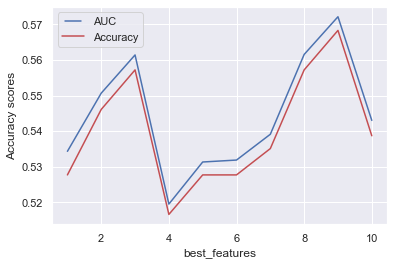

In [76]:
## max_depth = 4
## n_estimators = 305

data = predictions_data['7']
data = data.replace([np.inf, -np.inf], 0)

accuracy_scores = []
auc_scores = []
best_features = list(range(1, 11))
for i in best_features:
    X = data.drop(columns=['home_winner', 'match_id', 'round', 'date'])
    X = X[list(ordered_feature_importance.sort_values(ascending=False).index)[:i]]
    y = data['home_winner']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
    
    forest = RandomForestClassifier(n_estimators = 305, max_depth = 4, random_state=42)
    forest.fit(X_train, y_train)
    forest_pred = forest.predict(X_test)
        
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, forest_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    auc_scores.append(roc_auc)
        
    score = np.round(accuracy_score(y_test, forest_pred), 4)
    accuracy_scores.append(score)
    print(accuracy_scores)
    
line1, = plt.plot(best_features, auc_scores, 'b', label="AUC")
line2, = plt.plot(best_features, accuracy_scores, 'r', label="Accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Accuracy scores')
plt.xlabel('best_features')
plt.show()

After experementing with our hyperparamenters, I obtained 56.8% prediction accuracy when using the 9 most signficant features 

## Gradient Boosting Tree

In [77]:
from sklearn.ensemble import GradientBoostingClassifier
n_estimators = list(range(1, 300, 20))
gradient_results = pd.DataFrame({'estimators': n_estimators})
for key in ['7']:
#for key in predictions_data:
    data = predictions_data[key]
    data = data.replace([np.inf, -np.inf, np.nan], 0)
    X = data.drop(columns=['home_winner', 'match_id', 'round', 'date'])
    y = data['home_winner']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    key_results = []
    for i in n_estimators:
        gradient = GradientBoostingClassifier(n_estimators = i, random_state=42)
        gradient.fit(X_train, y_train)
        gradient_pred = gradient.predict(X_test)
        score = np.round(accuracy_score(y_test, gradient_pred), 4)
        key_results.append(score)
        print('Previous ' + key + ' matches - ' + str(i) + ' estimators accuracy: ' + str(np.round(score, 4)))
    #gradient_results[key] = key_results
#gradient_results = gradient_results.set_index('estimators')
#gradient_results

Previous 7 matches - 1 estimators accuracy: 0.5498
Previous 7 matches - 21 estimators accuracy: 0.5314
Previous 7 matches - 41 estimators accuracy: 0.572
Previous 7 matches - 61 estimators accuracy: 0.583
Previous 7 matches - 81 estimators accuracy: 0.5756
Previous 7 matches - 101 estimators accuracy: 0.5535
Previous 7 matches - 121 estimators accuracy: 0.5609
Previous 7 matches - 141 estimators accuracy: 0.5461
Previous 7 matches - 161 estimators accuracy: 0.5351
Previous 7 matches - 181 estimators accuracy: 0.5277
Previous 7 matches - 201 estimators accuracy: 0.5277
Previous 7 matches - 221 estimators accuracy: 0.5351
Previous 7 matches - 241 estimators accuracy: 0.5387
Previous 7 matches - 261 estimators accuracy: 0.5387
Previous 7 matches - 281 estimators accuracy: 0.5277


## Conclusion

From the accuracy scores obtained above, it looks like the Gradient Boosting Tree is the best model to use for predicting match outcomes. Random Forest looks to be a close second. I will play around with the features some more and test them using both models as both produced similar results.

## To Do

1. Add a feature which represents the number of lineup changes on a week to week basis and see if that has an impact on predictions. 
    - Former rugby player turned data scientist Ben Darwin describes in this [article](https://www.rugbypass.com/news/the-ex-wallabies-prop-with-keen-eye-for-fascinating-analytics-darwin-australia/) how making frequent changes to a team's lineup decreases their probabily of winning
2. Further feature selection
    - Look for collinearity between existing features
    - Play around with additional features that could benefit the prediction algorithm
3. Modify the formula used to calculate team stats at the beginning of the season when previous games played for that season is a small sample size
4. Compare predictions to pre-match betting odds and see if betting odds can further improve the algorithm

## Adding lineup changes as a feature + dropping other features

In [44]:
query = pd.read_sql_query('''
    SELECT * 
    FROM PlayerMatchStats
''', mydb)
player_stat_df = pd.DataFrame(query)
player_stat_df.head()

for match in Matches.all_matches:
    match_id = Matches.all_matches[match].id
    home_id = Matches.all_matches[match].home.id
    home_df = player_stat_df[(player_stat_df['match_id'] == match_id) & (player_stat_df['team_id'] == home_id)]
    home_roster = list(home_df['player_id'])
    
    away_id = Matches.all_matches[match].away.id
    away_df = player_stat_df[(player_stat_df['match_id'] == match_id) & (player_stat_df['team_id'] == away_id)]
    away_roster = list(away_df['player_id'])
#match_stat_df = player_stat_df.groupby(['match_id','team_id']).sum().reset_index()
#match_stat_df = match_stat_df.drop(columns=['id', 'player_id', 'position_id', 'minutes_played'])

,id,match_id,player_id,team_id,position_id,minutes_played,points,tries,conversions,conversion_attempts,...,kicked_dead,errors,handling_errors,one_on_ones_lost,penalties,on_report,sin_bins,send_offs,stint_one,stint_two
0,1,1,385,14,1,80.0,0,0,0,0,...,0,0,0,0,1,0,0,0,80.0,None
1,2,1,481,14,2,80.0,0,0,0,0,...,0,1,1,0,0,0,0,0,80.0,None
2,3,1,378,14,3,80.0,4,1,0,0,...,0,0,0,0,0,0,0,0,80.0,None
3,4,1,388,14,3,80.0,0,0,0,0,...,0,3,2,0,0,0,0,0,80.0,None
4,5,1,482,14,2,80.0,4,1,0,0,...,0,1,1,0,0,0,0,0,80.0,None


In [ ]:
for match in Matches.all_matches:
    match_id = Matches.all_matches[match].id
    home_id = Matches.all_matches[match].home.id
    home_df = player_stat_df[(player_stat_df['match_id'] == match_id) & (player_stat_df['team_id'] == home_id)]
    home_roster = list(home_df['player_id'])
    
    away_id = Matches.all_matches[match].away.id
    away_df = player_stat_df[(player_stat_df['match_id'] == match_id) & (player_stat_df['team_id'] == away_id)]
    away_roster = list(away_df['player_id'])
    

In [137]:
results_df.head()
prediction_percent = len(results_df[results_df['correct_prediction'] == True]) / results_df.shape[0]
betting_percent = len(results_df[results_df['correct_odds'] == True]) / results_df.shape[0]                                   
print('prediction_percentage = ' + str(prediction_percent))
print('betting_percentage = ' + str(betting_percent))

prediction_percentage = 0.58
betting_percentage = 0.62


In [78]:
mycursor.close()

True